In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# Create a new folder
os.mkdir('/content/gdrive/My Drive/Crypto')


In [ ]:
import pandas as pd
import requests
from pathlib import Path
from tqdm import tqdm

def download_ohlc_data_from_coinbase(
    product_id: str = "BTC-USD",
    from_day: str = "2022-01-01",
    to_day: str = "2023-06-01",
):
    days = pd.date_range(start=from_day, end=to_day, freq="1D")
    days = [day.strftime("%Y-%m-%d") for day in days]

    data = pd.DataFrame()

    for day in tqdm(days, desc="Downloading data"):
        file_name = f'{day}.parquet'
        file_path = Path(file_name)

        if file_path.exists():
            print(f'File {file_name} already exists, skipping')
            data_one_day = pd.read_parquet(file_path)
        else:
            print(f'Downloading data for {day}')
            data_one_day = download_data_for_one_day(product_id, day)
            data_one_day.to_parquet(file_name, index=False)

        data = pd.concat([data, data_one_day])

    # Save the combined data
    combined_file_name = "ohlc_data.parquet"
    data.to_parquet(combined_file_name, index=False)

    return combined_file_name

In [ ]:
def download_data_for_one_day(product_id, day):
    start = f'{day}T00:00:00'
    from datetime import datetime, timedelta
    end = (datetime.strptime(day, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
    end = f'{end}T00:00:00'

    URL = f'https://api.exchange.coinbase.com/products/{product_id}/candles?start={start}&end={end}&granularity=3600'
    r = requests.get(URL)
    data = r.json()

    return pd.DataFrame(data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])

In [ ]:
download_ohlc_data_from_coinbase(product_id="BTC-USD", from_day="2021-06-01", to_day="2023-06-01")

'ohlc_data.parquet'

In [ ]:
df = pd.read_parquet('/content/ohlc_data.parquet')
df.head()

time       low      high      open     close      volume
0  1622592000  36043.99  36891.50  36684.99  36176.78  633.280419
1  1622588400  36428.23  36800.00  36433.97  36685.00  536.037105
2  1622584800  36223.34  36593.61  36425.70  36429.11  580.230723
3  1622581200  36042.96  36487.77  36338.10  36425.70  483.362132
4  1622577600  35868.13  36353.80  35983.18  36332.75  516.862098

In [ ]:
import pickle

dataset = df

file_path = '/content/gdrive/MyDrive/Crypto/dataset.pkl'

# Save the dataset to a file
with open(file_path, 'wb') as file:
    pickle.dump('dataset', file)

print(f'Dataset saved to {file_path}')


Dataset saved to /content/gdrive/MyDrive/Crypto/dataset.pkl


In [ ]:
df = df.set_index('time')

In [ ]:
df.head()

low      high      open     close      volume
time                                                          
1622592000  36043.99  36891.50  36684.99  36176.78  633.280419
1622588400  36428.23  36800.00  36433.97  36685.00  536.037105
1622584800  36223.34  36593.61  36425.70  36429.11  580.230723
1622581200  36042.96  36487.77  36338.10  36425.70  483.362132
1622577600  35868.13  36353.80  35983.18  36332.75  516.862098

In [ ]:
df.index = pd.to_datetime(df.index, unit='s', origin='unix')
df.sample(10)

low      high      open     close       volume
time                                                                    
2022-11-10 05:00:00  16431.20  16737.03  16435.41  16673.69  4090.584427
2021-10-02 00:00:00  47623.49  48250.00  48165.76  47836.05   637.619464
2022-12-03 20:00:00  16912.97  16960.62  16953.79  16935.37   381.248513
2022-11-15 01:00:00  16502.85  16785.09  16538.16  16694.32  1758.488496
2023-02-15 03:00:00  22074.37  22143.69  22079.51  22107.34   222.536541
2021-08-17 22:00:00  44405.39  44950.00  44767.10  44914.10   757.703092
2022-11-02 21:00:00  20061.58  20188.76  20174.69  20152.61  1337.121842
2023-01-29 09:00:00  23163.42  23377.43  23178.20  23301.74   700.885742
2023-03-30 13:00:00  28418.81  28654.00  28652.74  28526.98   869.070322
2023-02-28 20:00:00  23172.85  23346.44  23266.97  23274.58   502.550709

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18271 entries, 2021-06-02 00:00:00 to 2023-06-01 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   low     18271 non-null  float64
 1   high    18271 non-null  float64
 2   open    18271 non-null  float64
 3   close   18271 non-null  float64
 4   volume  18271 non-null  float64
dtypes: float64(5)
memory usage: 856.5 KB


In [ ]:
df.isnull().sum()

low       0
high      0
open      0
close     0
volume    0
dtype: int64

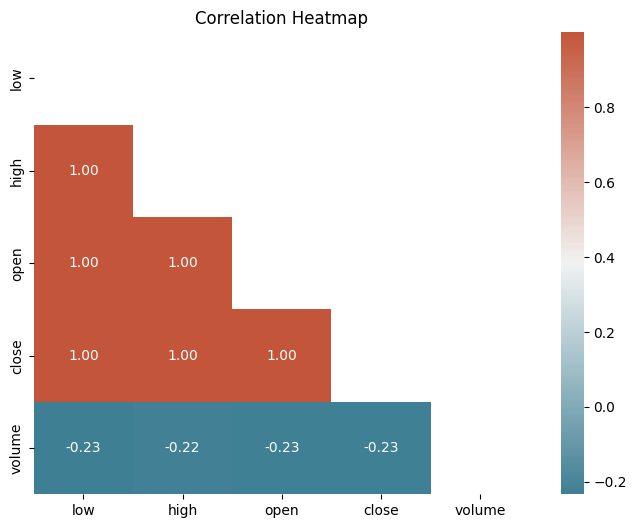

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
import plotly.graph_objects as go

# Create the candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close']
)])

# Customize the figure layout
fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=True,
)

# Show the plot
fig.show()


In [ ]:
# Group by 3-month intervals and sum the volume
data = df.resample('3M').sum()

# Create the scatter plot
fig = go.Figure(data=go.Scatter(
    x=data.index,
    y=data['volume'],
    mode='lines+markers'
))

# Customize the figure layout
fig.update_layout(
    title='Time vs. Volume (Grouped by 3 Months)',
    xaxis_title='Time',
    yaxis_title='Volume',
)

# Show the plot
fig.show()

In [ ]:
# Group by 3-month intervals and calculate the mean high-low difference
data_3m = df.resample('3M').mean()

# Calculate the high-low difference within each 3-month interval
data_3m['volatility'] = data_3m['high'] - data_3m['low']

# Create the time vs. 3-month high-low difference plot
fig = go.Figure(data=go.Scatter(
    x=data_3m.index,
    y=data_3m['volatility'],
    mode='lines+markers'
))

# Customize the figure layout
fig.update_layout(
    title='Time vs. Volatility',
    xaxis_title='Time',
    yaxis_title='Volatility',
)

# Show the plot
fig.show()


In [ ]:
# Calculate the Bollinger Bands
data = df
window = 48  # Adjust this window size as needed
data['SMA'] = data['close'].rolling(window=window).mean()
data['upper_band'] = data['SMA'] + 2 * data['close'].rolling(window=window).std()
data['lower_band'] = data['SMA'] - 2 * data['close'].rolling(window=window).std()

# Create a Plotly figure
fig = go.Figure()

# Plot the price
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='Price', line=dict(color='blue')))

# Plot the Bollinger Bands
fig.add_trace(go.Scatter(x=data.index, y=data['SMA'], mode='lines', name=f'{window}-hour SMA', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data.index, y=data['upper_band'], mode='lines', name='Upper Bollinger Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index, y=data['lower_band'], mode='lines', name='Lower Bollinger Band', line=dict(color='red')))

# Add fill between upper and lower bands
fig.add_trace(go.Scatter(x=data.index, y=data['upper_band'], fill='tozeroy', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=data.index, y=data['lower_band'], fill='tonexty', line=dict(width=0), showlegend=False))

# Customize the layout
fig.update_layout(
    title='Bollinger Bands',
    xaxis_title='Date',
    yaxis_title='Price',
    legend=dict(x=0.02, y=0.98),
    showlegend=True,
)

# Show the plot
fig.show()


In [ ]:
df.sample(10)

low      high      open     close       volume  \
time                                                                       
2022-01-20 09:00:00  41816.48  42105.84  41973.85  42071.79   239.268780   
2022-11-30 14:00:00  16804.64  16883.87  16808.17  16849.26  2007.075961   
2023-02-03 01:00:00  23527.75  23595.35  23557.46  23560.48   212.747588   
2022-05-04 12:00:00  38852.05  39159.46  38992.58  38958.75   900.119024   
2022-06-12 16:00:00  27773.60  28139.44  28052.11  27893.06   468.152329   
2023-04-13 04:00:00  30073.30  30143.78  30103.26  30084.65   145.101503   
2022-06-26 22:00:00  20953.16  21397.80  21373.48  21137.18  1237.041750   
2021-10-22 16:00:00  60000.00  61385.06  60661.40  61148.29  1992.687580   
2021-08-30 22:00:00  47569.99  48468.00  48399.80  47634.81   983.754496   
2022-05-11 06:00:00  30350.00  31514.65  31426.97  30489.58   958.139524   

                              SMA    upper_band    lower_band  
time                                                           
2022-01-20 09:00:00  42061.660417  43182.269661  40941.051172  
2022-11-30 14:00:00  16504.831042  17132.060962  15877.601122  
2023-02-03 01:00:00  23637.465625  24064.835958  23210.095292  
2022-05-04 12:00:00  38647.260417  39812.479258  37482.041575  
2022-06-12 16:00:00  28843.074792  30781.753172  26904.396411  
2023-04-13 04:00:00  30142.333542  30545.907276  29738.759807  
2022-06-26 22:00:00  21154.764792  21515.650569  20793.879015  
2021-10-22 16:00:00  63488.189792  66777.083855  60199.295728  
2021-08-30 22:00:00  48666.477708  49670.828617  47662.126799  
2022-05-11 06:00:00  31091.698750  33564.218244  28619.179256

# Models

In [ ]:
df.sample(10)

low      high      open     close       volume  \
time                                                                       
2022-10-07 13:00:00  19506.44  19708.37  19615.74  19604.66  3094.262361   
2022-01-27 04:00:00  35722.00  36015.32  35776.84  35943.51   765.949711   
2022-08-27 12:00:00  20184.00  20249.08  20214.26  20196.13   441.480144   
2023-02-12 20:00:00  21950.60  22036.49  21999.20  21967.97   344.524274   
2021-12-23 01:00:00  48103.01  48500.00  48307.67  48487.43   664.949882   
2022-10-04 19:00:00  20051.05  20279.78  20134.99  20230.47  1882.614849   
2023-03-17 11:00:00  26642.51  27033.04  26775.84  26988.38  1614.688783   
2022-12-13 16:00:00  17713.43  17834.84  17751.46  17750.74  2172.033252   
2021-06-27 19:00:00  32585.37  32968.97  32725.92  32825.09   279.399387   
2021-07-10 02:00:00  33644.71  33869.93  33771.11  33731.37   234.492505   

                              SMA    upper_band    lower_band  
time                                                           
2022-10-07 13:00:00  19996.902917  20584.337342  19409.468491  
2022-01-27 04:00:00  36981.974375  38454.942253  35509.006497  
2022-08-27 12:00:00  20921.625000  22266.909833  19576.340167  
2023-02-12 20:00:00  21759.346042  21937.964854  21580.727229  
2021-12-23 01:00:00  49110.901667  50736.559209  47485.244124  
2022-10-04 19:00:00  19420.586875  20143.830577  18697.343173  
2023-03-17 11:00:00  25396.748542  27405.029176  23388.467907  
2022-12-13 16:00:00  17192.868542  17761.905435  16623.831649  
2021-06-27 19:00:00  32658.423125  35378.592236  29938.254014  
2021-07-10 02:00:00  33447.950625  34256.895450  32639.005800

In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["day_of_year"] = df.index.dayofyear
df["quarter"] = df.index.quarter

In [ ]:
df.sample(10)

low      high      open     close       volume  \
time                                                                       
2022-03-26 18:00:00  44389.22  44496.00  44399.01  44463.99   208.074063   
2021-06-20 06:00:00  35475.10  35758.85  35724.27  35497.32   428.866425   
2022-12-20 19:00:00  16835.21  16912.10  16835.21  16898.63  1261.669533   
2021-09-26 00:00:00  42338.38  42769.31  42705.51  42606.40   345.312558   
2021-11-15 04:00:00  65728.02  65888.85  65745.61  65800.21   240.014276   
2022-08-23 21:00:00  21428.00  21508.21  21477.79  21487.67   473.242060   
2022-09-05 14:00:00  19724.05  19880.92  19741.81  19843.01   631.374811   
2022-08-09 21:00:00  23132.55  23220.65  23145.86  23199.27   356.488597   
2022-04-17 23:00:00  39553.07  40011.79  40011.79  39683.54   817.441885   
2021-11-12 20:00:00  63858.38  64376.92  63868.90  64148.79   507.514213   

                              SMA    upper_band    lower_band  year  month  \
time                                                                         
2022-03-26 18:00:00  43940.096875  45277.997044  42602.196706  2022      3   
2021-06-20 06:00:00  35588.843958  37394.462574  33783.225343  2021      6   
2022-12-20 19:00:00  16712.238333  16923.830365  16500.646301  2022     12   
2021-09-26 00:00:00  43529.456042  45544.443083  41514.469000  2021      9   
2021-11-15 04:00:00  64653.043125  66157.375061  63148.711189  2021     11   
2022-08-23 21:00:00  21316.177500  21591.619674  21040.735326  2022      8   
2022-09-05 14:00:00  19831.764375  20009.118266  19654.410484  2022      9   
2022-08-09 21:00:00  23448.243542  24365.227058  22531.260025  2022      8   
2022-04-17 23:00:00  40284.435625  40706.122739  39862.748511  2022      4   
2021-11-12 20:00:00  65694.758958  68222.859944  63166.657973  2021     11   

                     day  hour  day_of_week  day_of_year  quarter  
time                                                               
2022-03-26 18:00:00   26    18            5           85        1  
2021-06-20 06:00:00   20     6            6          171        2  
2022-12-20 19:00:00   20    19            1          354        4  
2021-09-26 00:00:00   26     0            6          269        3  
2021-11-15 04:00:00   15     4            0          319        4  
2022-08-23 21:00:00   23    21            1          235        3  
2022-09-05 14:00:00    5    14            0          248        3  
2022-08-09 21:00:00    9    21            1          221        3  
2022-04-17 23:00:00   17    23            6          107        2  
2021-11-12 20:00:00   12    20            4          316        4

In [ ]:
print(min(df.index))
print(max(df.index))

2021-06-01 00:00:00
2023-06-02 00:00:00


In [ ]:
training_mask = df.index < "2023-02-01 00:00:00"
train = df.loc[training_mask]
print(train.shape)

testing_mask = df.index >= "2023-02-01 00:00:00"
test = df.loc[testing_mask]
print(test.shape)

(15249, 15)
(3022, 15)


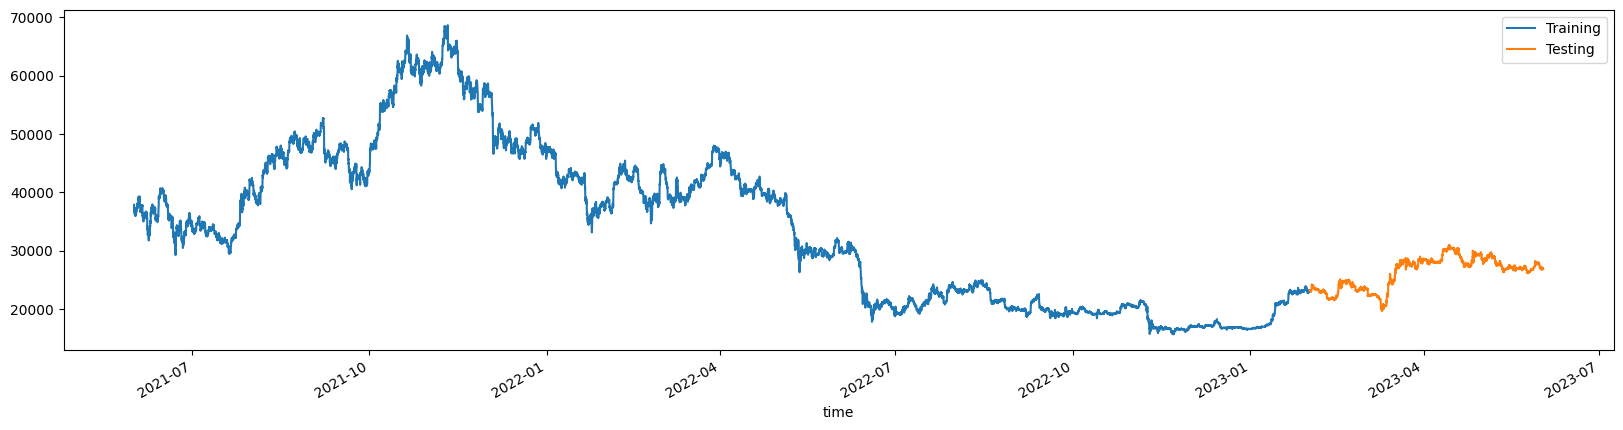

In [ ]:
figure, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, label="Training", y="close")
test.plot(ax=ax, label="Testing", y="close")
plt.show()

In [ ]:
X_train = train[["day","day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = train["close"]

X_test = test[["day","day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = test["close"]

In [ ]:
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()
X_train.head()

time  day  day_of_week  day_of_year  month  quarter  year
0 2021-06-02 00:00:00    2            2          153      6        2  2021
1 2021-06-01 23:00:00    1            1          152      6        2  2021
2 2021-06-01 22:00:00    1            1          152      6        2  2021
3 2021-06-01 21:00:00    1            1          152      6        2  2021
4 2021-06-01 20:00:00    1            1          152      6        2  2021

In [ ]:
X_train = X_train.drop(['time'],axis=1)
y_train = y_train.drop(['time'],axis=1)
X_test = X_test.drop(['time'],axis=1)
y_test = y_test.drop(['time'],axis=1)
X_train.head()

day  day_of_week  day_of_year  month  quarter  year
0    2            2          153      6        2  2021
1    1            1          152      6        2  2021
2    1            1          152      6        2  2021
3    1            1          152      6        2  2021
4    1            1          152      6        2  2021

In [ ]:
# Import necessary libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror')

# Train the model
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:12393.22995	validation_1-rmse:7265.45616
[1]	validation_0-rmse:11281.93709	validation_1-rmse:6088.36860
[2]	validation_0-rmse:10249.61787	validation_1-rmse:5162.27075
[3]	validation_0-rmse:9331.62087	validation_1-rmse:4337.29755
[4]	validation_0-rmse:8511.67733	validation_1-rmse:3709.02291
[5]	validation_0-rmse:7781.49213	validation_1-rmse:3206.83742
[6]	validation_0-rmse:7151.01704	validation_1-rmse:2848.79183
[7]	validation_0-rmse:6521.74240	validation_1-rmse:2685.40089
[8]	validation_0-rmse:5960.14159	validation_1-rmse:2674.61112
[9]	validation_0-rmse:5459.75218	validation_1-rmse:2761.70516
[10]	validation_0-rmse:5014.26168	validation_1-rmse:2922.30300
[11]	validation_0-rmse:4627.62425	validation_1-rmse:3126.58191
[12]	validation_0-rmse:4278.91961	validation_1-rmse:3339.00528
[13]	validation_0-rmse:3964.63058	validation_1-rmse:3559.28918
[14]	validation_0-rmse:3693.75915	validation_1-rmse:3781.32929
[15]	validation_0-rmse:3445.78641	validation_1-rmse:3979.97726

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

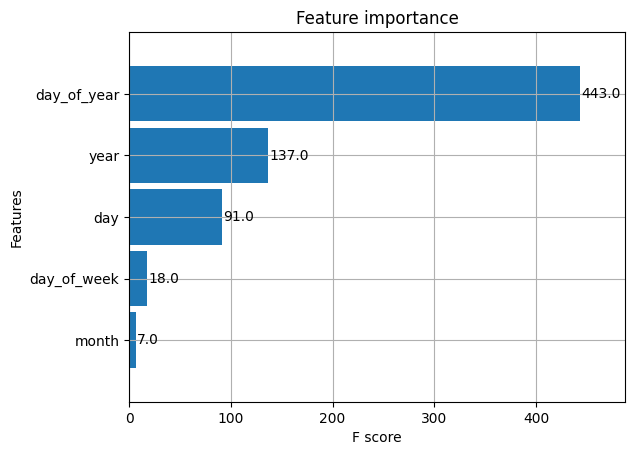

In [ ]:
from xgboost import plot_importance
_ = plot_importance(model, height=0.9)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

MAE: 4731.708799248222
MSE: 29801833.860934
MAPE: 0.17497762695537075


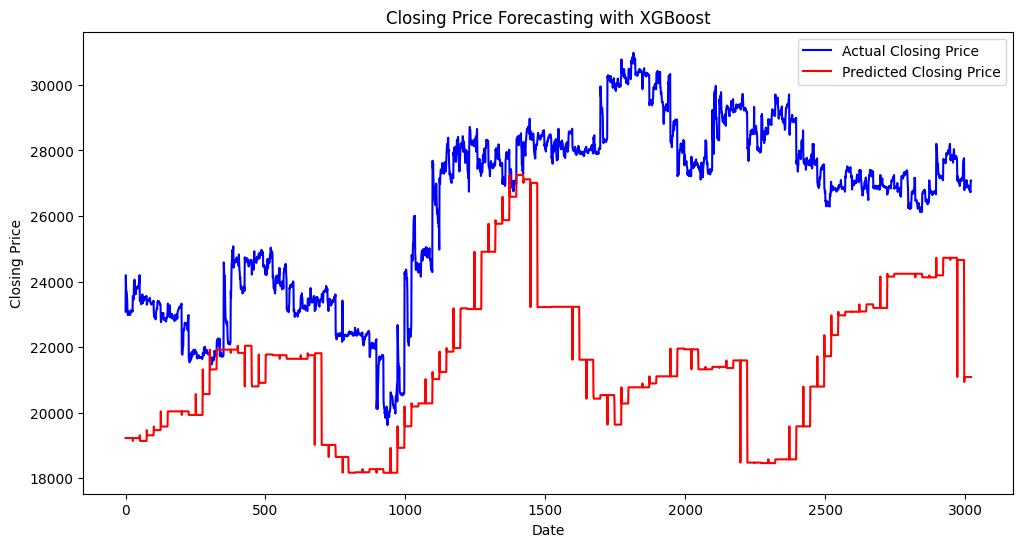

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
evaluate_model(y_test,y_pred)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual Closing Price', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Closing Price', color='red')
plt.title('Closing Price Forecasting with XGBoost')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV

cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


bayes_search = BayesSearchCV(estimator=model, cv=cv_split, search_spaces=parameters)
bayes_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point b

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
              search_spaces={'colsample_bytree': [0.3, 0.5, 0.7],
                             'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                             'max_depth': [3, 4, 6, 5, 10],
                             'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [ ]:
bayes_search.best_params_

OrderedDict([('colsample_bytree', 0.5),
             ('learning_rate', 0.1),
             ('max_depth', 3),
             ('n_estimators', 1000)])

MAE: 4384.6527911074
MSE: 32075434.018749446
MAPE: 0.1637073739556281


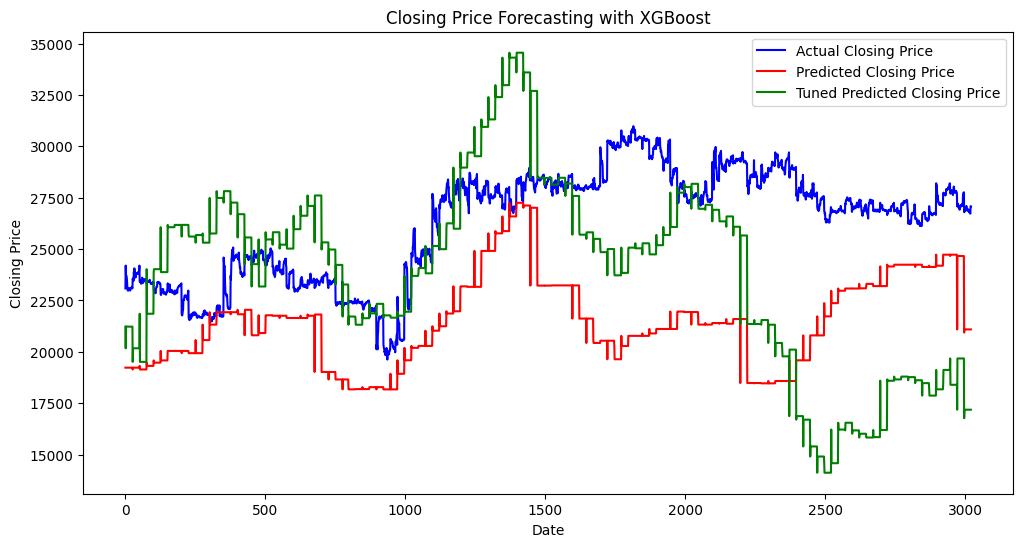

In [ ]:
# Make predictions on the test set
y_pred_hp = bayes_search.predict(X_test)

# Evaluate the model
evaluate_model(y_test,y_pred_hp)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual Closing Price', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Closing Price', color='red')
plt.plot(X_test.index, y_pred_hp, label='Tuned Predicted Closing Price', color='green')
plt.title('Closing Price Forecasting with XGBoost')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Lagged/Shifted dataset model

In [ ]:
df.sample(10)

low      high      open     close       volume  \
time                                                                       
2021-07-22 01:00:00  31897.57  32095.16  32071.35  31978.43   261.995535   
2022-11-06 06:00:00  21146.47  21192.10  21156.50  21174.51   200.760035   
2022-08-05 11:00:00  23151.22  23448.00  23200.27  23411.58  1561.758124   
2022-04-15 18:00:00  40360.23  40477.00  40444.16  40395.10   246.740812   
2023-04-23 21:00:00  27478.20  27555.28  27507.94  27516.39   208.908770   
2022-10-19 02:00:00  19249.06  19322.07  19314.05  19292.17   445.944787   
2022-12-05 09:00:00  17285.69  17366.41  17361.09  17309.21   974.535999   
2023-05-20 12:00:00  26886.62  26955.26  26887.33  26903.45   105.434668   
2022-12-16 20:00:00  16854.50  16957.11  16866.99  16871.62  2100.451324   
2021-11-20 02:00:00  58812.10  59058.97  58851.84  58860.31   500.558121   

                              SMA    upper_band    lower_band  year  month  \
time                                                                         
2021-07-22 01:00:00  31688.613750  33178.563574  30198.663926  2021      7   
2022-11-06 06:00:00  21193.322083  21778.489536  20608.154631  2022     11   
2022-08-05 11:00:00  22925.251250  23380.429201  22470.073299  2022      8   
2022-04-15 18:00:00  40444.227083  41575.281332  39313.172835  2022      4   
2023-04-23 21:00:00  27714.929792  28430.136867  26999.722716  2023      4   
2022-10-19 02:00:00  19335.388125  19681.885914  18988.890336  2022     10   
2022-12-05 09:00:00  17052.256042  17254.067059  16850.445025  2022     12   
2023-05-20 12:00:00  27010.004375  27394.196476  26625.812274  2023      5   
2022-12-16 20:00:00  17595.908958  18298.791943  16893.025974  2022     12   
2021-11-20 02:00:00  58009.976042  60060.024314  55959.927769  2021     11   

                     day  hour  day_of_week  day_of_year  quarter  
time                                                               
2021-07-22 01:00:00   22     1            3          203        3  
2022-11-06 06:00:00    6     6            6          310        4  
2022-08-05 11:00:00    5    11            4          217        3  
2022-04-15 18:00:00   15    18            4          105        2  
2023-04-23 21:00:00   23    21            6          113        2  
2022-10-19 02:00:00   19     2            2          292        4  
2022-12-05 09:00:00    5     9            0          339        4  
2023-05-20 12:00:00   20    12            5          140        2  
2022-12-16 20:00:00   16    20            4          350        4  
2021-11-20 02:00:00   20     2            5          324        4

In [ ]:
df['24h_pct'] = df['close'].pct_change(24)
df.sample(10)

low      high      open     close       volume  \
time                                                                       
2022-03-05 05:00:00  38809.99  39028.96  38873.29  39022.15   290.193448   
2022-04-10 11:00:00  42524.04  42739.97  42540.53  42701.16   110.650731   
2023-03-03 06:00:00  22336.86  22409.40  22350.40  22384.53   463.837497   
2021-08-11 14:00:00  46200.00  46688.04  46297.29  46519.32   700.324714   
2022-07-28 12:00:00  22580.86  23199.92  23120.32  23043.51  2040.648820   
2021-10-06 16:00:00  54485.48  55054.64  54999.25  54898.22  1174.908772   
2023-04-11 10:00:00  30029.47  30172.21  30080.75  30145.99   415.896988   
2023-02-04 00:00:00  23385.00  23464.54  23433.47  23413.51   267.611739   
2023-03-07 21:00:00  21944.42  22115.49  22054.64  22055.64   656.026778   
2021-12-08 10:00:00  49244.81  50369.82  50176.26  49289.31   703.514918   

                              SMA    upper_band    lower_band  year  month  \
time                                                                         
2022-03-05 05:00:00  40356.149792  43120.210983  37592.088600  2022      3   
2022-04-10 11:00:00  42762.258542  43709.532052  41814.985031  2022      4   
2023-03-03 06:00:00  22990.425208  24038.499293  21942.351123  2023      3   
2021-08-11 14:00:00  45354.933958  47316.570491  43393.297426  2021      8   
2022-07-28 12:00:00  22124.423958  24368.404312  19880.443605  2022      7   
2021-10-06 16:00:00  50366.599583  55433.663893  45299.535274  2021     10   
2023-04-11 10:00:00  29053.699375  30865.045370  27242.353380  2023      4   
2023-02-04 00:00:00  23484.302500  24234.273189  22734.331811  2023      2   
2023-03-07 21:00:00  22397.423958  22581.885716  22212.962200  2023      3   
2021-12-08 10:00:00  50380.701250  52220.126275  48541.276225  2021     12   

                     day  hour  day_of_week  day_of_year  quarter   24h_pct  
time                                                                         
2022-03-05 05:00:00    5     5            5           64        1 -0.057022  
2022-04-10 11:00:00   10    11            6          100        2  0.004977  
2023-03-03 06:00:00    3     6            4           62        1 -0.045364  
2021-08-11 14:00:00   11    14            2          223        3  0.020936  
2022-07-28 12:00:00   28    12            3          209        3  0.086695  
2021-10-06 16:00:00    6    16            2          279        4  0.102012  
2023-04-11 10:00:00   11    10            1          101        2  0.063916  
2023-02-04 00:00:00    4     0            5           35        1 -0.003419  
2023-03-07 21:00:00    7    21            1           66        1 -0.013148  
2021-12-08 10:00:00    8    10            2          342        4 -0.039685

In [ ]:
df['24h_f'] = df['close'].shift(-24)
df['24h_fpct'] = df['24h_f'].pct_change(24)
df.sample(10)

low      high      open     close       volume  \
time                                                                       
2022-11-16 14:00:00  16400.00  16564.50  16497.65  16467.63  3321.822418   
2021-07-18 01:00:00  31961.86  32450.00  31991.62  32222.06   506.083495   
2021-08-27 16:00:00  48012.01  48313.44  48212.66  48211.46   310.685192   
2021-07-20 08:00:00  29630.03  29892.62  29830.53  29637.06   437.620846   
2022-12-23 13:00:00  16745.05  16943.29  16870.80  16841.46  2892.908134   
2021-10-28 23:00:00  60347.89  60813.33  60524.45  60591.65   667.216544   
2022-02-05 16:00:00  41255.34  41893.72  41802.86  41307.19   774.331442   
2023-03-30 20:00:00  27899.37  28200.00  27991.90  28150.21   993.871990   
2022-03-10 10:00:00  38996.91  39267.78  39166.05  39065.01   443.830866   
2021-08-08 14:00:00  43875.00  44897.40  44788.00  43948.03   986.867028   

                              SMA    upper_band    lower_band  year  month  \
time                                                                         
2022-11-16 14:00:00  16651.910208  17195.846734  16107.973683  2022     11   
2021-07-18 01:00:00  31673.869792  32120.484599  31227.254984  2021      7   
2021-08-27 16:00:00  47732.030208  49291.260741  46172.799676  2021      8   
2021-07-20 08:00:00  30743.988750  32560.273653  28927.703847  2021      7   
2022-12-23 13:00:00  16801.770625  16938.374602  16665.166648  2022     12   
2021-10-28 23:00:00  60841.827917  64133.191699  57550.464134  2021     10   
2022-02-05 16:00:00  38782.988750  42717.026206  34848.951294  2022      2   
2023-03-30 20:00:00  27681.771667  28953.479149  26410.064185  2023      3   
2022-03-10 10:00:00  40359.430000  43426.968356  37291.891644  2022      3   
2021-08-08 14:00:00  42912.826875  45760.153984  40065.499766  2021      8   

                     day  hour  day_of_week  day_of_year  quarter   24h_pct  \
time                                                                          
2022-11-16 14:00:00   16    14            2          320        4 -0.031150   
2021-07-18 01:00:00   18     1            6          199        3  0.018391   
2021-08-27 16:00:00   27    16            4          239        3  0.030229   
2021-07-20 08:00:00   20     8            1          201        3 -0.062286   
2022-12-23 13:00:00   23    13            4          357        4  0.001550   
2021-10-28 23:00:00   28    23            3          301        4  0.030610   
2022-02-05 16:00:00    5    16            5           36        1  0.045616   
2023-03-30 20:00:00   30    20            3           89        1 -0.009787   
2022-03-10 10:00:00   10    10            3           69        1 -0.070630   
2021-08-08 14:00:00    8    14            6          220        3  0.016845   

                        24h_f  24h_fpct  
time                                     
2022-11-16 14:00:00  16525.91  0.003539  
2021-07-18 01:00:00  31524.51 -0.021648  
2021-08-27 16:00:00  49039.27  0.017170  
2021-07-20 08:00:00  31321.86  0.056848  
2022-12-23 13:00:00  16831.34 -0.000601  
2021-10-28 23:00:00  61943.99  0.022319  
2022-02-05 16:00:00  41676.34  0.008937  
2023-03-30 20:00:00  28486.94  0.011962  
2022-03-10 10:00:00  39919.18  0.021865  
2021-08-08 14:00:00  45909.16  0.044624

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4641    0  4641    0     0  13737      0 --:--:-- --:--:-- --:--:-- 13730
100  517k  100  517k    0     0   378k      0  0:00:01  0:00:01 --:--:-- 1741k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4641    0  4641    0     0   9159      0 --:--:-- --:--:-- --:--:--  9171
100  392k  100  392k    0     0   269k      0  0:00:01  0:00:01 --:--:--  454k


In [ ]:
df['ma168'] = talib.SMA(df['close'].values, timeperiod=168)
df['rsi168'] = talib.RSI(df['close'].values, timeperiod=168)

In [ ]:
df.head(10)

low      high      open     close      volume  SMA  \
time                                                                           
2021-06-02 00:00:00  36043.99  36891.50  36684.99  36176.78  633.280419  NaN   
2021-06-01 23:00:00  36428.23  36800.00  36433.97  36685.00  536.037105  NaN   
2021-06-01 22:00:00  36223.34  36593.61  36425.70  36429.11  580.230723  NaN   
2021-06-01 21:00:00  36042.96  36487.77  36338.10  36425.70  483.362132  NaN   
2021-06-01 20:00:00  35868.13  36353.80  35983.18  36332.75  516.862098  NaN   
2021-06-01 19:00:00  35783.24  36233.68  36218.01  35983.15  692.496391  NaN   
2021-06-01 18:00:00  36106.27  36496.90  36158.19  36214.41  844.298979  NaN   
2021-06-01 17:00:00  35728.00  36248.75  35930.91  36158.19  785.319587  NaN   
2021-06-01 16:00:00  35761.77  36468.20  36234.00  35930.91  792.260957  NaN   
2021-06-01 15:00:00  36018.00  36636.38  36631.92  36236.61  642.733596  NaN   

                     upper_band  lower_band  year  month  day  hour  \
time                                                                  
2021-06-02 00:00:00         NaN         NaN  2021      6    2     0   
2021-06-01 23:00:00         NaN         NaN  2021      6    1    23   
2021-06-01 22:00:00         NaN         NaN  2021      6    1    22   
2021-06-01 21:00:00         NaN         NaN  2021      6    1    21   
2021-06-01 20:00:00         NaN         NaN  2021      6    1    20   
2021-06-01 19:00:00         NaN         NaN  2021      6    1    19   
2021-06-01 18:00:00         NaN         NaN  2021      6    1    18   
2021-06-01 17:00:00         NaN         NaN  2021      6    1    17   
2021-06-01 16:00:00         NaN         NaN  2021      6    1    16   
2021-06-01 15:00:00         NaN         NaN  2021      6    1    15   

                     day_of_week  day_of_year  quarter  24h_pct     24h_f  \
time                                                                        
2021-06-02 00:00:00            2          153        2      NaN  37849.85   
2021-06-01 23:00:00            1          152        2      NaN  37478.57   
2021-06-01 22:00:00            1          152        2      NaN  37577.91   
2021-06-01 21:00:00            1          152        2      NaN  37538.86   
2021-06-01 20:00:00            1          152        2      NaN  37800.65   
2021-06-01 19:00:00            1          152        2      NaN  37741.92   
2021-06-01 18:00:00            1          152        2      NaN  37883.12   
2021-06-01 17:00:00            1          152        2      NaN  38022.23   
2021-06-01 16:00:00            1          152        2      NaN  38017.00   
2021-06-01 15:00:00            1          152        2      NaN  37887.71   

                     24h_fpct  ma168  rsi168  
time                                          
2021-06-02 00:00:00       NaN    NaN     NaN  
2021-06-01 23:00:00       NaN    NaN     NaN  
2021-06-01 22:00:00       NaN    NaN     NaN  
2021-06-01 21:00:00       NaN    NaN     NaN  
2021-06-01 20:00:00       NaN    NaN     NaN  
2021-06-01 19:00:00       NaN    NaN     NaN  
2021-06-01 18:00:00       NaN    NaN     NaN  
2021-06-01 17:00:00       NaN    NaN     NaN  
2021-06-01 16:00:00       NaN    NaN     NaN  
2021-06-01 15:00:00       NaN    NaN     NaN

In [ ]:
print(len(df))
df = df.dropna()
print(len(df))

18271
18079


In [ ]:
df.isnull().sum()

low            0
high           0
open           0
close          0
volume         0
SMA            0
upper_band     0
lower_band     0
year           0
month          0
day            0
hour           0
day_of_week    0
day_of_year    0
quarter        0
24h_pct        0
24h_f          0
24h_fpct       0
ma168          0
rsi168         0
dtype: int64

In [ ]:
print(min(df.index))
print(max(df.index))

2021-06-07 00:00:00
2023-06-02 00:00:00


(15081, 20)
(2998, 20)


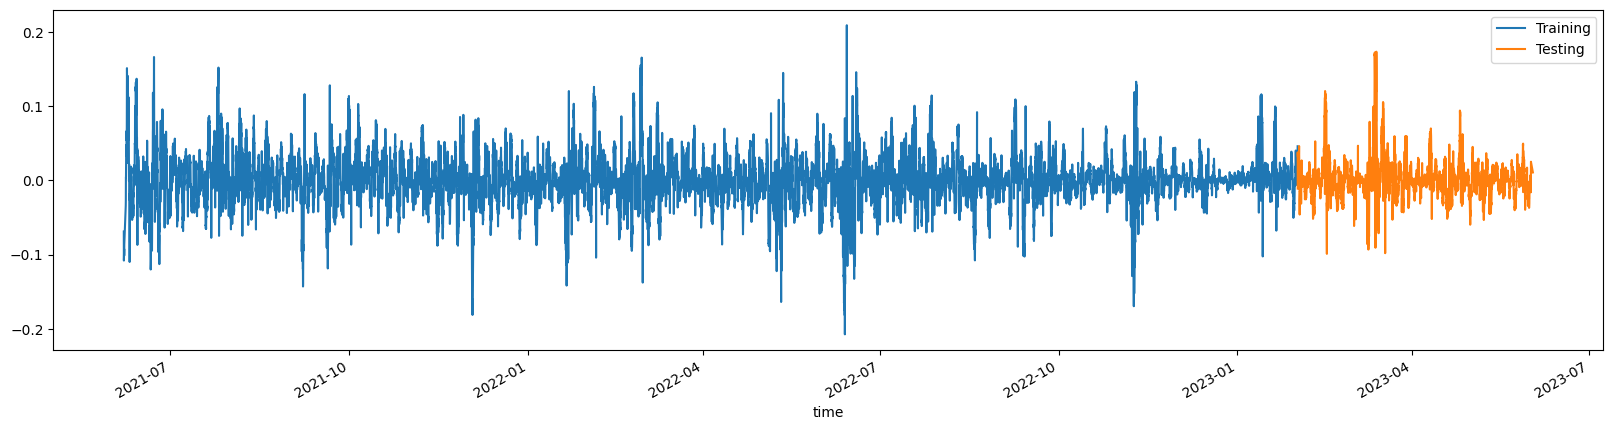

In [ ]:
training_mask = df.index < "2023-02-01 00:00:00"
train = df.loc[training_mask]
print(train.shape)
testing_mask = df.index >= "2023-02-01 00:00:00"
test = df.loc[testing_mask]
print(test.shape)
figure, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, label="Training", y="24h_fpct")
test.plot(ax=ax, label="Testing", y="24h_fpct")
plt.show()

In [ ]:
X_train = train[["day","day_of_week", "day_of_year", "month", "quarter", "year", "volume","24h_pct", "24h_f", "24h_fpct", "ma168",
       "rsi168"]]
y_train = train["close"]

X_test = test[["day","day_of_week", "day_of_year", "month", "quarter", "year", "volume","24h_pct", "24h_f", "24h_fpct", "ma168",
       "rsi168"]]
y_test = test["close"]
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()
X_train.head()

time  day  day_of_week  day_of_year  month  quarter  year  \
0 2021-06-07 06:00:00    7            0          158      6        2  2021   
1 2021-06-07 05:00:00    7            0          158      6        2  2021   
2 2021-06-07 04:00:00    7            0          158      6        2  2021   
3 2021-06-07 03:00:00    7            0          158      6        2  2021   
4 2021-06-07 02:00:00    7            0          158      6        2  2021   

       volume   24h_pct     24h_f  24h_fpct         ma168     rsi168  
0  289.936471 -0.004288  32979.31 -0.086310  36849.867024  49.915355  
1  342.457217  0.005548  32627.60 -0.101237  36847.591905  50.130579  
2  286.839692  0.006853  32925.00 -0.092198  36846.638333  50.095337  
3  380.483401  0.006456  32869.08 -0.096907  36846.462262  50.227541  
4  359.147264  0.011064  32847.19 -0.103870  36848.377440  50.495504

In [ ]:
X_train = X_train.drop(['time'],axis=1)
y_train = y_train.drop(['time'],axis=1)
X_test = X_test.drop(['time'],axis=1)
y_test = y_test.drop(['time'],axis=1)
X_train.head()

day  day_of_week  day_of_year  month  quarter  year      volume   24h_pct  \
0    7            0          158      6        2  2021  289.936471 -0.004288   
1    7            0          158      6        2  2021  342.457217  0.005548   
2    7            0          158      6        2  2021  286.839692  0.006853   
3    7            0          158      6        2  2021  380.483401  0.006456   
4    7            0          158      6        2  2021  359.147264  0.011064   

      24h_f  24h_fpct         ma168     rsi168  
0  32979.31 -0.086310  36849.867024  49.915355  
1  32627.60 -0.101237  36847.591905  50.130579  
2  32925.00 -0.092198  36846.638333  50.095337  
3  32869.08 -0.096907  36846.462262  50.227541  
4  32847.19 -0.103870  36848.377440  50.495504

In [ ]:
cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(objective='reg:squarederror')
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


bayes_search = BayesSearchCV(estimator=model, cv=cv_split, search_spaces=parameters)
bayes_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
              search_spaces={'colsample_bytree': [0.3, 0.5, 0.7],
                             'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                             'max_depth': [3, 4, 6, 5, 10],
                             'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [ ]:
bayes_search.best_params_

OrderedDict([('colsample_bytree', 0.7),
             ('learning_rate', 0.2),
             ('max_depth', 3),
             ('n_estimators', 300)])

MAE: 884.9937303775433
MSE: 1229990.2997484163
MAPE: 0.032258715291756994


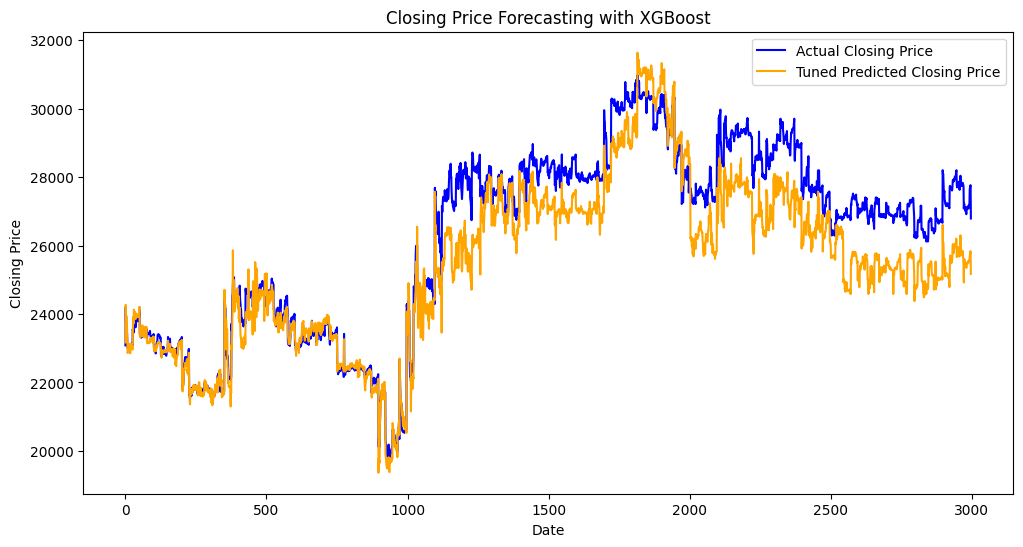

In [ ]:
# Make predictions on the test set
y_pred_hp_pct = bayes_search.predict(X_test)

# Evaluate the model
evaluate_model(y_test,y_pred_hp_pct)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual Closing Price', color='blue')
#plt.plot(X_test.index, y_pred, label='Predicted Closing Price', color='red')
#plt.plot(X_test.index, y_pred_hp, label='Tuned Predicted Closing Price', color='green')
plt.plot(X_test.index, y_pred_hp_pct, label='Tuned Predicted Closing Price', color='orange')
plt.title('Closing Price Forecasting with XGBoost')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

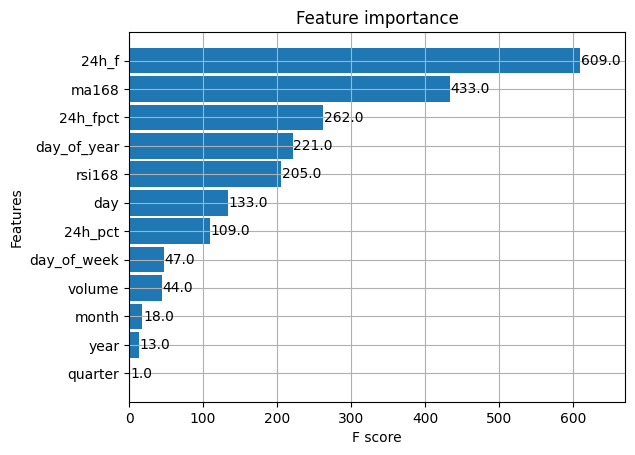

In [ ]:
_ = plot_importance(bayes_search.best_estimator_, height=0.9)

In [ ]:
import joblib
best_estimator = bayes_search.best_estimator_
joblib.dump(best_estimator, '/content/gdrive/MyDrive/Crypto/models/xgboost.pkl')


['/content/gdrive/MyDrive/Crypto/models/xgboost.pkl']

Training RMSE: 177.48512695287428
Validation RMSE: 1109.0492774211687


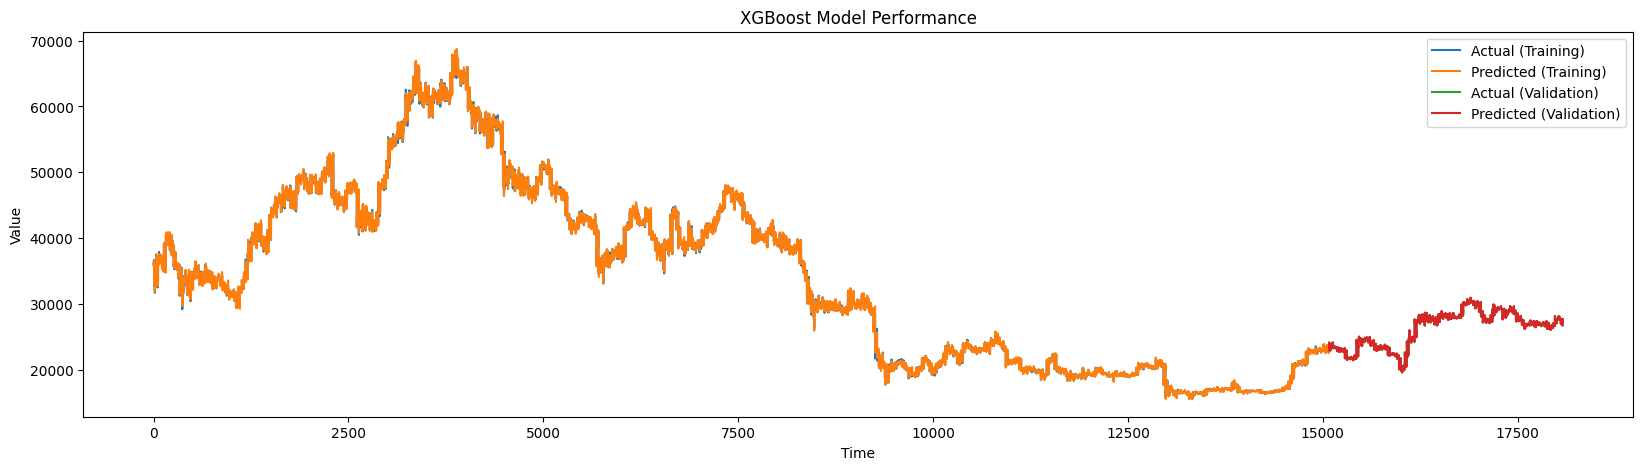

In [ ]:
# Make predictions on the training and validation data
y_train_pred = bayes_search.predict(X_train)
y_valid_pred = bayes_search.predict(X_test)

# Calculate RMSE (Root Mean Squared Error) for training and validation sets
train_MAE =  mean_absolute_error(y_train, y_train_pred)
train_RMSE =  np.sqrt(mean_squared_error(y_train, y_train_pred))
train_MAPE = mean_absolute_percentage_error(y_train, y_train_pred)
valid_MAE =  mean_absolute_error(y_test, y_valid_pred)
valid_RMSE =  np.sqrt(mean_squared_error(y_test, y_valid_pred))
valid_MAPE = mean_absolute_percentage_error(y_test, y_valid_pred)

print(f"Training RMSE: {train_RMSE}")
print(f"Validation RMSE: {valid_RMSE}")

# Visualize the training and validation performance over time
figure, ax = plt.subplots(figsize=(20, 5))
plt.plot(y_train, label="Actual (Training)")
plt.plot(y_train_pred, label="Predicted (Training)")
plt.plot(len(y_train) + np.arange(len(y_test)), y_test, label="Actual (Validation)")
plt.plot(len(y_train) + np.arange(len(y_test)), y_test, label="Predicted (Validation)")
plt.legend()
plt.title("XGBoost Model Performance")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


# Deep Learning Model

In [ ]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_exte

In [ ]:
pip install kaleido python_multipart uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
df = df.reset_index()

In [ ]:
df = df[['time','close']]
df.head()

time     close
0 2021-06-07 06:00:00  36094.65
1 2021-06-07 05:00:00  36302.78
2 2021-06-07 04:00:00  36268.91
3 2021-06-07 03:00:00  36396.12
4 2021-06-07 02:00:00  36654.50

In [ ]:
from copy import deepcopy as dc
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('time', inplace=True)

    for i in range(1, n_steps+1):
        df[f'close(t-{i})'] = df['close'].shift(i)

    df.dropna(inplace=True)

    return df

def scale_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def prepare_data_for_lstm(data, lookback):
    shifted_df = prepare_dataframe_for_lstm(data, lookback)
    shifted_data, scaler = scale_data(shifted_df.to_numpy())

    X = shifted_data[:, 1:]
    y = shifted_data[:, 0]

    X = dc(np.flip(X, axis=1))

    split_index = int(len(X) * 0.95)

    X_train = X[:split_index]
    X_test = X[split_index:]

    y_train = y[:split_index]
    y_test = y[split_index:]

    X_train = X_train.reshape((-1, lookback, 1))
    X_test = X_test.reshape((-1, lookback, 1))

    y_train = y_train.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))

    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()
    X_test = torch.tensor(X_test).float()
    y_test = torch.tensor(y_test).float()

    return X_train, X_test, y_train, y_test

# Usage:
lookback = 24
X_train, X_test, y_train, y_test = prepare_data_for_lstm(df, lookback)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([17152, 24, 1]),
 torch.Size([903, 24, 1]),
 torch.Size([17152, 1]),
 torch.Size([903, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 24

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([24, 24, 1]) torch.Size([24, 1])


In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # Print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0

    # Validation
    model.eval()
    running_loss = 0.0
    test_rmse = 0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            y_pred = model(x_batch)
            test_loss = loss_fn(y_pred, y_batch)
            test_rmse += np.sqrt(test_loss.item())
            running_loss += test_loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Val Loss: {avg_loss_across_batches:.3f} | Test RMSE: {test_rmse:.5f}")
    print('***************************************************')


Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Epoch: 0 | Loss: 0.00029, Val Loss: 0.000 | Test RMSE: 0.25136
***************************************************
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Epoch: 1 | Loss: 0.00008, Val Loss: 0.000 | Test RMSE: 0.30725
***************************************************
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Epoch: 2 | Loss: 0.00070, Val Loss: 0.000 | Test RMSE: 0.24706
***************************************************
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Epoch: 3 | 

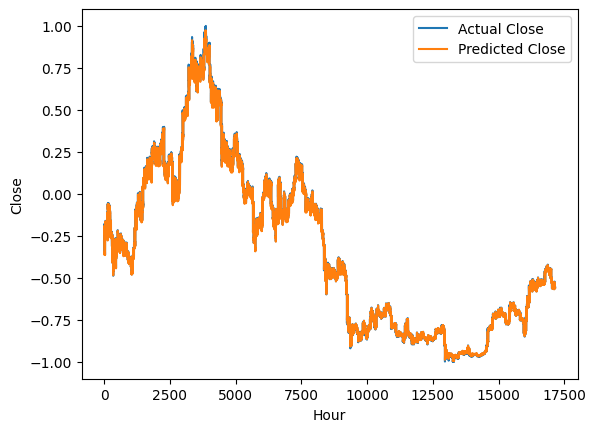

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Hour')
plt.ylabel('Close')
plt.legend()
plt.show()


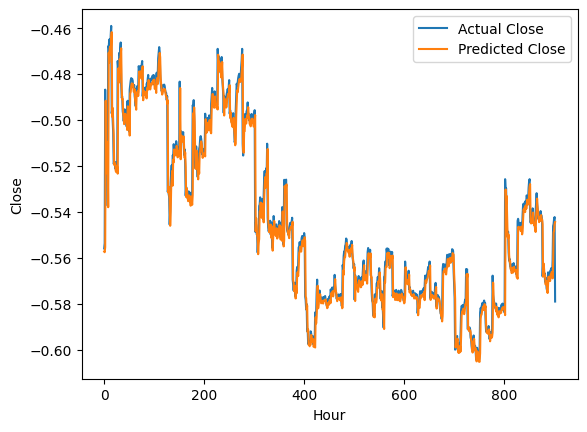

In [ ]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Hour')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(model=model,
               target_dir="/content/gdrive/MyDrive/Crypto/models",
               model_name="tsmodel.pth")

[INFO] Saving model to: /content/gdrive/MyDrive/Crypto/models/tsmodel.pth
